In [1]:
from lambeq import BobcatParser, AtomicType, IQPAnsatz
from lambeq import Rewriter, remove_cups
from lambeq import Dataset, QuantumTrainer, SPSAOptimizer, NumpyModel, TketModel  
from lambeq.core.utils import flatten

from pytket.extensions.qiskit import tk_to_qiskit, AerBackend

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

/home/jovyan/.qbraid/environments/womanium_go14xk/pyenv/lib/python3.9/site-packages/lambeq/text2diagram/ccg_parser.py:24: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [16]:
BATCH_SIZE = 30  ## batch size of training data if don't want to use full training dataset at once
EPOCHS = 600    ## number of epochs for training the model
SEED = 2

## Read in data

In [3]:
def read_data(filename):
    labels, sentence_pairs = [], []
    with open(filename) as f:
        for line in f:
            l = line.strip().split(',')
            labels.append(int(l[2]))  #, 1-int(l[2])]) ## using only one label per data
            sentence_pairs.append([l[0]]+ [l[1]])
            
    return labels, sentence_pairs

labels, sentence_pairs = read_data('datasets/MC1.txt')
train_labels1, train_data1 = labels[:80], sentence_pairs[:80]  # for now first 60 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels1, test_data1 = labels[80:], sentence_pairs[80:]    # rest is test data

In [4]:
train_data1[:5], train_labels1[:5], test_data1[:5], test_labels1[:5]

([['cook creates complicated dish',
   ' experienced chef prepares complicated dish'],
  ['skilful programmer creates code', ' devoted hacker writes code'],
  ['skilful cook creates meal', ' devoted hacker creates complicated code'],
  ['hacker writes code', ' skilful hacker creates code'],
  ['devoted hacker writes code', ' hacker writes complicated code']],
 [1, 1, 0, 1, 1],
 [['devoted hacker creates complicated code',
   ' skilful cook prepares complicated meal'],
  ['chef creates complicated meal', ' cook prepares tasty dish'],
  ['chef prepares tasty meal', ' chef prepares meal'],
  ['programmer writes code', ' cook prepares complicated meal'],
  ['hacker writes advanced code', ' hacker creates code']],
 [0, 1, 1, 0, 1])

## Create a random dataset from the given data by shuffling

In [5]:
sentence_pairs1, labels1  = Dataset.shuffle_data(sentence_pairs, labels) ## returns data, target

train_labels, train_data = labels1[:80], sentence_pairs1[:80]  # for now first 80 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels, test_data = labels1[80:], sentence_pairs1[80:]    # rest is test data

In [6]:
train_data[:5], train_labels[:5], test_data[:5], test_labels[:5]

([['skilful cook prepares tasty dish', ' hacker creates code'],
  ['devoted programmer creates advanced code',
   ' skilful programmer writes advanced code'],
  ['experienced chef prepares complicated dish', ' skilful cook creates meal'],
  ['hacker writes code', ' devoted hacker creates code'],
  ['skilful chef creates meal', ' skilful hacker creates advanced code']],
 [0, 1, 1, 1, 0],
 [['skilful programmer creates complicated code',
   ' programmer writes complicated code'],
  ['programmer writes complicated code', ' skilful cook creates tasty dish'],
  ['cook creates complicated meal', ' cook prepares dish'],
  ['devoted hacker writes complicated code',
   ' devoted programmer creates complicated code'],
  ['skilful hacker writes code', ' cook creates meal']],
 [1, 0, 1, 1, 0])

## Create and check diagrams

In [7]:
parser = BobcatParser(verbose='suppress')  ## to select particular type of words like nouns use 'root_cats' parameter

raw_train_diagrams = [parser.sentences2diagrams(d) for d in train_data] # can send list of list of str to the function
#raw_dev_diagrams = [parser.sentences2diagrams(d) for d in dev_data]
raw_test_diagrams = [parser.sentences2diagrams(d) for d in test_data]

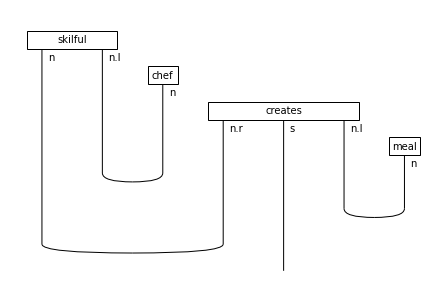

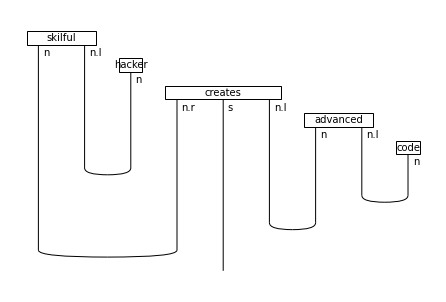

(['skilful chef creates meal', ' skilful hacker creates advanced code'],
 None,
 None)

In [8]:
train_data[4], raw_train_diagrams[4][0].draw(), raw_train_diagrams[4][1].draw()

## Filter and simply string diagrams

In [9]:
## First filter out those diagrams which could not be parsed

## before filtering
#print(len(raw_train_diagrams), len(raw_dev_diagrams), len(raw_test_diagrams))

train_diagrams, train_labels_final = [], []
dev_diagrams, dev_labels_final = [], []
test_diagrams, test_labels_final = [], []

for diagram, label in zip(raw_train_diagrams, train_labels):
    if diagram[0] is not None and diagram[1] is not None:
        train_diagrams.append(remove_cups(diagram))
        train_labels_final.append(label)
        
# for diagram, label in zip(raw_dev_diagrams, dev_labels):
#     if diagram[0] is not None and diagram[1] is not None:
#         dev_diagrams.append(remove_cups(diagram))
#         dev_labels_final.append(label)

for diagram, label in zip(raw_test_diagrams, test_labels):
    if diagram[0] is not None and diagram[1] is not None:
        test_diagrams.append(remove_cups(diagram))
        test_labels_final.append(label)

print(len(train_diagrams), len(dev_diagrams), len(test_diagrams))

80 0 20


## Create circuits

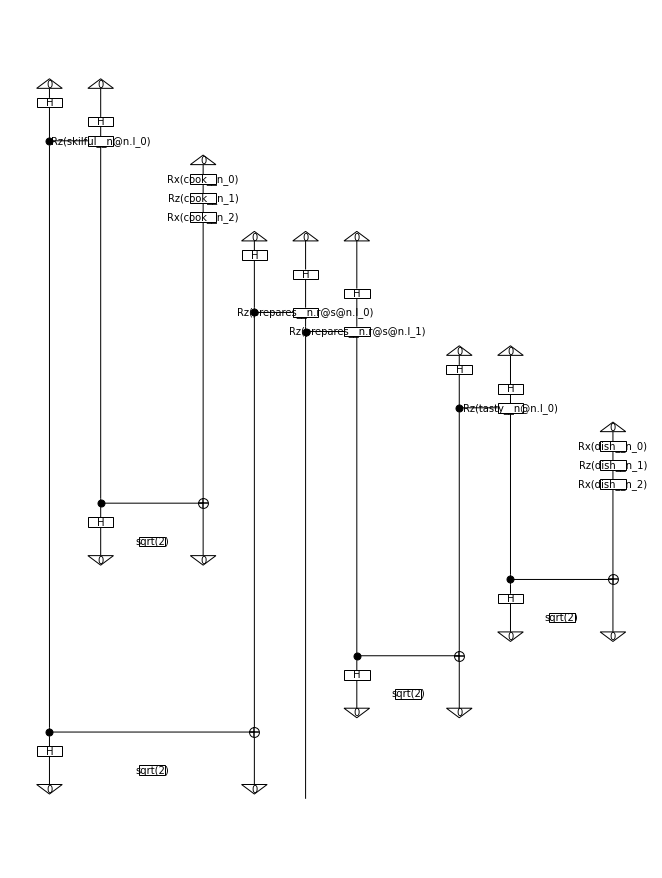

In [10]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3) 

train_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in train_diagrams]
#dev_circuits =  [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in dev_diagrams]
test_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in test_diagrams]

train_circuits[0][0].draw(figsize=(9, 12))

## Parameterise

In [17]:
## JAX backend

#all_circuits = train_circuits + dev_circuits + test_circuits
#all_circuits = [d for d in flatten(train_circuits)] + [d for d in flatten(dev_circuits)] + [d for d in flatten(test_circuits)]
all_circuits = [d for d in flatten(train_circuits)] + [d for d in flatten(test_circuits)]

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)
#model1 = NumpyModel.from_diagrams(train_circuits, use_jit=True) # cann't take list of list

In [12]:
## Aer backend
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
qmodel = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

## Define Loss and accuracy function

In [12]:
def loss_func_1(y_hat, y):
    ## cosine similarity and binary cross-entropy loss function
    
    y_hat_new  = []
    y_new = []
    eps = 10**-9
    
    for i in range(0, len(y_hat), 2):
        cos_sim = np.dot(y_hat[i], y_hat[i+1])/(np.linalg.norm(y_hat[i])*np.linalg.norm(y_hat[i+1]))
        #cos_sim = np.dot(np.sqrt(y_hat[i]), np.sqrt(y_hat[i+1]))
        y_hat_new.append(cos_sim) 
        y_new.append(y[i])
        
    loss =  -np.sum(np.array(y_new) * np.log(np.array(y_hat_new)+eps)) / len(y_new) # binary cross-entropy loss
    
    return loss
    
def loss_func_2(y_hat, y):
    ## cosine similarity and mean squared error
    
    y_hat_new  = []
    y_new = []
    
    
    for i in range(0, len(y_hat), 2):
        cos_sim = np.dot(y_hat[i], y_hat[i+1])/(np.linalg.norm(y_hat[i])*np.linalg.norm(y_hat[i+1]))
        #cos_sim = np.dot(np.sqrt(y_hat[i]), np.sqrt(y_hat[i+1]))
        y_hat_new.append(cos_sim)
        y_new.append(y[i])
    
    loss = np.sum((np.array(y_new) - np.array(y_hat_new))**2)/len(y_new)
            
    return loss


def accuracy_func(y_hat, y):
    y_hat_new  = []
    y_new = []
    
    for i in range(0, len(y_hat), 2):
        cos_sim = np.dot(y_hat[i], y_hat[i+1])/(np.linalg.norm(y_hat[i])*np.linalg.norm(y_hat[i+1]))
        #cos_sim = np.dot(np.sqrt(y_hat[i]), np.sqrt(y_hat[i+1]))
        theta = np.rad2deg(np.arccos(min(1.0, cos_sim)))
        if theta < 20:
            y_hat_new.append(1) 
        else:
            y_hat_new.append(0) 
        y_new.append(y[i])
    
    acc = 0
    for i,j in zip (y_hat_new, y_new):
        if i==j:
            acc += 1
            
    return acc/len(y_new)

## Define trainer and create dataset

In [18]:
trainer = QuantumTrainer(
    model,
    loss_function=loss_func_2,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': accuracy_func},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

In [14]:
train_dataset = Dataset([d for d in flatten(train_circuits)], np.repeat(train_labels_final, 2, axis=0),  batch_size=BATCH_SIZE*2, shuffle=False)

## Train the model

In [19]:
trainer.fit(train_dataset, logging_step=20) #with single valued cos_sim and cross-entropy loss

Epoch 1:    train/loss: 0.3799   valid/loss: -----   train/acc: 0.4500   valid/acc: -----
Epoch 20:   train/loss: 0.3737   valid/loss: -----   train/acc: 0.4625   valid/acc: -----
Epoch 40:   train/loss: 0.3534   valid/loss: -----   train/acc: 0.4875   valid/acc: -----
Epoch 60:   train/loss: 0.3361   valid/loss: -----   train/acc: 0.5750   valid/acc: -----
Epoch 80:   train/loss: 0.3234   valid/loss: -----   train/acc: 0.5750   valid/acc: -----
Epoch 100:  train/loss: 0.3047   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 120:  train/loss: 0.2914   valid/loss: -----   train/acc: 0.5875   valid/acc: -----
Epoch 140:  train/loss: 0.2876   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 160:  train/loss: 0.2643   valid/loss: -----   train/acc: 0.6625   valid/acc: -----
Epoch 180:  train/loss: 0.2571   valid/loss: -----   train/acc: 0.6750   valid/acc: -----
Epoch 200:  train/loss: 0.2406   valid/loss: -----   train/acc: 0.6750   valid/acc: -----
Epoch 220:

## Plot the loss and accuracy during training, and check model prediction accuracy with test dataset

Test accuracy: 1.0


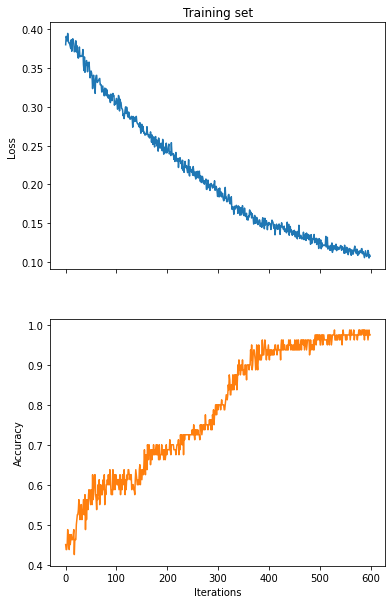

In [20]:
fig, (ax_t, ax_b) = plt.subplots(2, 1, sharex=True, sharey='row', figsize=(6, 10))
ax_t.set_title('Training set')
#ax_tr.set_title('Development set')
ax_b.set_xlabel('Iterations')
#ax_br.set_xlabel('Iterations')
ax_b.set_ylabel('Accuracy')
ax_t.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_t.plot(trainer.train_epoch_costs, color=next(colours))
ax_b.plot(trainer.train_results['acc'], color=next(colours))
#ax_tr.plot(trainer.val_costs, color=next(colours))
#ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = accuracy_func(model([d for d in flatten(test_circuits)]), np.repeat(test_labels_final, 2, axis=0))
print('Test accuracy:', test_acc)

In [22]:
model.make_checkpoint('datasets/cos_sim_mse_model')

## Check the circuit output for test dataset

In [21]:
y_hat, y = model([d for d in flatten(test_circuits)]), np.repeat(test_labels_final, 2, axis=0)

In [22]:
y_hat_new  = []
y_new = []
ang = []
cos = []

for i in range(0, len(y_hat), 2):
    cos_sim = np.dot(y_hat[i], y_hat[i+1])/(np.linalg.norm(y_hat[i])*np.linalg.norm(y_hat[i+1]))
    theta = np.rad2deg(np.arccos(min(1.0, cos_sim)))
    ang.append(theta);cos.append(cos_sim)
    if theta <= 20:
        y_hat_new.append(1) 
    else:
        y_hat_new.append(0) 
    y_new.append(y[i])
acc = 0
for i, j in zip(y_hat_new, y_new):
    if i==j:
        acc += 1
print(acc/len(y_new))

1.0


In [23]:
j = 0
for i,a in enumerate(ang):
    print('truth %d, prediction %d, angel %f cos_sim %f' %(y_new[i], y_hat_new[i], a, cos[i]))
    print(y_hat[j:j+2])
    j += 2

truth 1, prediction 1, angel 5.438587 cos_sim 0.995498
[[0.8123625  0.18763745]
 [0.7498959  0.25010413]]
truth 0, prediction 0, angel 49.191238 cos_sim 0.653536
[[0.7498959  0.25010413]
 [0.2915041  0.70849586]]
truth 1, prediction 1, angel 3.034865 cos_sim 0.998598
[[0.1126157  0.88738436]
 [0.15336454 0.8466354 ]]
truth 1, prediction 1, angel 13.176252 cos_sim 0.973673
[[0.9128588 0.0871412]
 [0.7478849 0.252115 ]]
truth 0, prediction 0, angel 70.465324 cos_sim 0.334377
[[0.9682819  0.03171809]
 [0.241472   0.758528  ]]
truth 0, prediction 0, angel 66.863686 cos_sim 0.392920
[[0.19783467 0.8021653 ]
 [0.85952246 0.1404775 ]]
truth 1, prediction 1, angel 13.857274 cos_sim 0.970895
[[0.13509886 0.8649011 ]
 [0.295294   0.704706  ]]
truth 0, prediction 0, angel 35.144989 cos_sim 0.817698
[[0.4521307  0.5478693 ]
 [0.7849202  0.21507972]]
truth 1, prediction 1, angel 3.730667 cos_sim 0.997881
[[0.9114137  0.08858625]
 [0.85952246 0.1404775 ]]
truth 1, prediction 1, angel 1.382818 cos_si